# Visualize ligand-receptor expressing pairs

This notebook colors cell types expressing particilar ligand/receptor genes within 5 microns of a neighboring leukemia cell to capture visual examples of receptor-ligand interactions.

In [1]:
import numpy as np
import cv2
import tifffile
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math
import seaborn as sns
from skimage import data, segmentation, util, measure
from skimage.segmentation import expand_labels
from numpy import ma 
from matplotlib import ticker, cm 

In [2]:
# define function to convert rgb color format to hex
def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

In [3]:
# path to cell typing results
pred_location = '/data/Zhaolab/1_AMLCosMx/Final_scripts/4_CellTyping/4_CelltypesByTranscript/FromGege/celltype_v8-EP.csv'

In [4]:
# path to cell-cell edge-edge distance matrices
dist_dir = '/data/Zhaolab/1_AMLCosMx/Final_scripts/5_SpatialAnalysis/1_MeasureCellDists/cell-cell_distances/'

In [5]:
# create dictionary of patient names
name_dirs = {'p1':'P51', 'p2':'P52', 'p3':'P53', 'p4':'P56', 'p5':'P57', 'p6':'P58'}
toGegeID = {'P51':'p1', 'P52':'p2', 'P53':'p3', 'P56':'p4', 'P57':'p5', 'P58':'p6'}

In [6]:
# read in celltype predictions
df = pd.read_csv(pred_location)

# reformat columns
df3 = pd.concat([df['x'], df['Unnamed: 0'].str.split('_', expand=True)], axis=1)
df3 = df3.rename(columns={"x": "celltype_detail", 0: "PtID", 3: "cell_id"})
df3['FOV'] = df3[1].apply(lambda x: x[-2:])
df3['patients'] = df3['PtID'].apply(lambda x: toGegeID[x])
df3 = df3.drop(columns=[1,2])
morph_predicted = df3[['patients', 'celltype_detail', 'FOV', 'cell_id']]
morph_predicted

,patients,celltype_detail,FOV,cell_id
0,p1,NoCellAssigned,01,0
1,p1,CD8TeffectorGZMK,01,1
2,p1,MonocytesCD16,01,2
3,p1,Mega,01,3
4,p1,Mega,01,4
...,...,...,...,...
625140,p6,ErythroidProgenitors,23,7962
625141,p6,MatureB,23,7963
625142,p6,ErythroidProgenitors,23,7966
625143,p6,Mega,23,7971


In [7]:
# define types to remove before further analysis
types_to_remove = ['NoCellAssigned','RBC','SmallCell','Unknown']
morph_predicted = morph_predicted[~morph_predicted['celltype_detail'].isin(types_to_remove)]
morph_predicted

,patients,celltype_detail,FOV,cell_id
1,p1,CD8TeffectorGZMK,01,1
2,p1,MonocytesCD16,01,2
3,p1,Mega,01,3
4,p1,Mega,01,4
5,p1,NK,01,5
...,...,...,...,...
625140,p6,ErythroidProgenitors,23,7962
625141,p6,MatureB,23,7963
625142,p6,ErythroidProgenitors,23,7966
625143,p6,Mega,23,7971


In [8]:
# load FOV metadata to add timepoint info
FOV_metadata = pd.read_csv('/data/Zhaolab/1_AMLCosMx/Final_scripts/4_CellTyping/FOV_metadata.csv', index_col=0)
FOV_metadata.loc['P57_FOV17'] = ['C', 'CR'] # add row for P57 FOV17

morph_predicted['Timepoint'] = ''
for i in range(morph_predicted.shape[0]):
    alt_pt_name = name_dirs[morph_predicted['patients'].iloc[i]]
    fov = morph_predicted['FOV'].iloc[i]
    sample = alt_pt_name + '_FOV' + fov
    morph_predicted['Timepoint'].iloc[i] = FOV_metadata['Timepoint'].loc[sample]
    
morph_predicted

/tmp/ipykernel_3182471/454863587.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morph_predicted['Timepoint'] = ''
/tmp/ipykernel_3182471/454863587.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morph_predicted['Timepoint'].iloc[i] = FOV_metadata['Timepoint'].loc[sample]


,patients,celltype_detail,FOV,cell_id,Timepoint
1,p1,CD8TeffectorGZMK,01,1,A
2,p1,MonocytesCD16,01,2,A
3,p1,Mega,01,3,A
4,p1,Mega,01,4,A
5,p1,NK,01,5,A
...,...,...,...,...,...
625140,p6,ErythroidProgenitors,23,7962,C
625141,p6,MatureB,23,7963,C
625142,p6,ErythroidProgenitors,23,7966,C
625143,p6,Mega,23,7971,C


In [9]:
# get cell type names
class_column = 'celltype_detail'
cluster_labels = list(set(morph_predicted[class_column].tolist()))
cluster_labels.sort()

# read colors from csv
colors = pd.read_csv('/data/Zhaolab/1_AMLCosMx/Final_scripts/4_CellTyping/4_CelltypesByTranscript/color_v8.csv', index_col=0)
colors = colors.T
cluster_colors = {}
for celltype in cluster_labels:
    cluster_colors[celltype] = [colors['blue'].loc[celltype], colors['green'].loc[celltype], colors['red'].loc[celltype]]
    
cell_types = list(cluster_colors.keys())

In [10]:
cell_types

['B',
 'CD4Tmemory',
 'CD4Tnaive',
 'CD8TeffectorGZMH',
 'CD8TeffectorGZMK',
 'CD8Tnaive',
 'DC',
 'ErythroidProgenitors',
 'LeukemiaCell',
 'MatureB',
 'Mega',
 'MonocytesCD14',
 'MonocytesCD16',
 'MonocytesProgenitor',
 'NK',
 'Plasma',
 'ProgenitorB']

## Get gene counts for each cell in each FOV

In [11]:
patients = ['p1', 'p2', 'p3', 'p4', 'p5', 'p6']

In [ ]:
All_fov_scores = []

for patient in patients:
    
    alt_pt_name = name_dirs[patient]
    
    # subset for patient
    one_patient = morph_predicted[morph_predicted['patients'] == patient]

    # create list of fovs
    fovs = list(set(one_patient['FOV'].tolist()))
    fovs.sort()

    for fov in fovs:
        
        single_fov = one_patient[one_patient['FOV'] == fov]

        # read in counts
        counts_by_read = pd.read_csv('/data/Zhaolab/1_AMLCosMx/Final_scripts/3_GenerateCounts/' + alt_pt_name + '_hybrid_counts/' + alt_pt_name + '_hybrid_FOV' + fov + '_counts_xy.csv', index_col=0, comment='#')
        counts_by_read['fov'] = counts_by_read['fov'].astype(str)
        counts_by_read['X'] = counts_by_read['fov'].str.zfill(2) + '_' + counts_by_read['cell_ID'].astype(str)
        counts_by_read = counts_by_read[['X', 'target']]

        # create unique identifier for each cell
        counts_by_read['combo'] = counts_by_read['X'] + '_' + counts_by_read['target']
        counts_by_read['count'] = 1

        # sum same read in same cell
        summed_reads = counts_by_read.groupby('combo')['count'].sum().to_frame()
        summed_reads = summed_reads.reset_index()

        # re-create unique identifier for each cell
        summed_reads[['FOV','cell_id','transcript']] = summed_reads['combo'].str.split('_',expand=True)
        summed_reads['X'] = patient + '_' + summed_reads['FOV'] + '_' + summed_reads['cell_id'].astype(str)

        # pivot to be cells x genes
        counts_by_cell = summed_reads.pivot(index='X', columns='transcript', values='count')
        counts_by_cell = counts_by_cell.fillna(0)

        single_fov['unique_id'] = single_fov['patients'] + '_' + single_fov['FOV'] + '_' + single_fov['cell_id'].astype(str)
        single_fov = single_fov.set_index('unique_id')

        # concat with cell type DF
        cells_with_score = single_fov.merge(counts_by_cell, how='left', left_index=True, right_index=True)
        
        # add to list of counts for each fov
        All_fov_scores.append(cells_with_score)

In [ ]:
All_fov_scores_df = pd.concat(All_fov_scores)
All_fov_scores_df

In [ ]:
# save output
#All_fov_scores_df.to_csv('GenesXCounts_all_FOVs.csv')

In [12]:
# load above DF
All_fov_scores_df = pd.read_csv('GenesXCounts_all_FOVs.csv', index_col=0)
All_fov_scores_df

,patients,celltype_detail,FOV,cell_id,Timepoint,AATK,ABL1,ABL2,ACE,ACE2,...,WNT5B,WNT7A,WNT7B,WNT9A,XBP1,XCL1,XCL2,YBX3,YES1,ZFP36
unique_id,,,,,,,,,,,,,,,,,,,,,
p1_01_1,p1,CD8TeffectorGZMK,1,1,A,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
p1_01_2,p1,MonocytesCD16,1,2,A,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
p1_01_3,p1,Mega,1,3,A,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
p1_01_4,p1,Mega,1,4,A,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0
p1_01_5,p1,NK,1,5,A,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p6_23_7962,p6,ErythroidProgenitors,23,7962,C,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
p6_23_7963,p6,MatureB,23,7963,C,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
p6_23_7966,p6,ErythroidProgenitors,23,7966,C,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Heatmap of pairs

### Ligand from leukemia, receptor from other

In [23]:
# load results csv
LR_results = pd.read_csv('LR_result1_update.csv', index_col=0)

# only look at pairs where close group reads elevated compared to far
LR_results['foldChange'] = LR_results['group0'] / LR_results['group1']
LR_results_up = LR_results[LR_results['foldChange'] > 0]

# only look at pairs where adjusted p < 1
LR_results_up_filt = LR_results_up[LR_results_up['p_adj'] < 1]
LR_results_up_filt

,receptor_gene,Timepoint,celltype,p,group0,group1,ligand_gene_malignant,patient,p_adj,foldChange
5418,ITGB6,C,DC,0.000311,0.067383,0.030777,VTN,1,0.446931,2.189421
8569,ITGB2,C,DC,0.000583,0.560000,0.843750,SELPLG,3,0.837995,0.663704
85691,ITGB2,C,DC,0.000583,0.560000,0.843750,APOB,3,0.837995,0.663704
9355,ENG,B,CD4Tmemory,0.000275,0.220339,0.413333,INHBA,3,0.395463,0.533078
12711,TNFRSF12A,B,CD4Tnaive,0.000034,0.648352,0.523438,TNFSF12,3,0.048923,1.238642
12715,TNFRSF12A,B,DC,0.000003,0.702439,0.573991,TNFSF12,3,0.004077,1.223780
12721,TNFRSF12A,B,MonocytesProgenitor,0.000054,0.735772,0.595318,TNFSF12,3,0.077462,1.235932
12872,CSF2RB,B,MonocytesCD16,0.000553,0.178947,0.254795,CSF2,3,0.795002,0.702320
85692,ITGB2,C,DC,0.000583,0.560000,0.843750,MMP9,3,0.837995,0.663704
6958,CD44,B,DC,0.000583,0.279570,0.561702,MMP7,6,0.837995,0.497719


In [24]:
# combine cell type and gene in one column
LR_results_up_filt['celltype_gene'] = LR_results_up_filt['celltype'] + '_' + LR_results_up_filt['receptor_gene']
LR_results_up_filt

/tmp/ipykernel_3182471/4208101301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LR_results_up_filt['celltype_gene'] = LR_results_up_filt['celltype'] + '_' + LR_results_up_filt['receptor_gene']


,receptor_gene,Timepoint,celltype,p,group0,group1,ligand_gene_malignant,patient,p_adj,foldChange,celltype_gene
5418,ITGB6,C,DC,0.000311,0.067383,0.030777,VTN,1,0.446931,2.189421,DC_ITGB6
8569,ITGB2,C,DC,0.000583,0.560000,0.843750,SELPLG,3,0.837995,0.663704,DC_ITGB2
85691,ITGB2,C,DC,0.000583,0.560000,0.843750,APOB,3,0.837995,0.663704,DC_ITGB2
9355,ENG,B,CD4Tmemory,0.000275,0.220339,0.413333,INHBA,3,0.395463,0.533078,CD4Tmemory_ENG
12711,TNFRSF12A,B,CD4Tnaive,0.000034,0.648352,0.523438,TNFSF12,3,0.048923,1.238642,CD4Tnaive_TNFRSF12A
12715,TNFRSF12A,B,DC,0.000003,0.702439,0.573991,TNFSF12,3,0.004077,1.223780,DC_TNFRSF12A
12721,TNFRSF12A,B,MonocytesProgenitor,0.000054,0.735772,0.595318,TNFSF12,3,0.077462,1.235932,MonocytesProgenitor_TNFRSF12A
12872,CSF2RB,B,MonocytesCD16,0.000553,0.178947,0.254795,CSF2,3,0.795002,0.702320,MonocytesCD16_CSF2RB
85692,ITGB2,C,DC,0.000583,0.560000,0.843750,MMP9,3,0.837995,0.663704,DC_ITGB2
6958,CD44,B,DC,0.000583,0.279570,0.561702,MMP7,6,0.837995,0.497719,DC_CD44


In [25]:
# pivot dataframe to format for heatmap
LR_results_pivoted = LR_results_up_filt.pivot(index='celltype_gene', columns='ligand_gene_malignant', values='p_adj')
LR_results_pivoted = LR_results_pivoted.fillna(1)
LR_results_pivoted

ligand_gene_malignant,APOB,CSF2,INHBA,MMP7,MMP9,SELPLG,TNFSF12,VTN
celltype_gene,,,,,,,,
CD4Tmemory_ENG,1.000000,1.000000,0.395463,1.000000,1.000000,1.000000,1.000000,1.000000
CD4Tnaive_TNFRSF12A,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.048923,1.000000
DC_CD44,1.000000,1.000000,1.000000,0.837995,1.000000,1.000000,1.000000,1.000000
DC_ITGB2,0.837995,1.000000,1.000000,1.000000,0.837995,0.837995,1.000000,1.000000
DC_ITGB6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.446931
DC_TNFRSF12A,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.004077,1.000000
MonocytesCD16_CSF2RB,1.000000,0.795002,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
MonocytesProgenitor_TNFRSF12A,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.077462,1.000000


In [26]:
LR_results_pivoted = LR_results_pivoted.reset_index()
LR_results_pivoted[['receptor_celltype','receptor_gene']] = LR_results_pivoted['celltype_gene'].str.split('_',expand=True)
del LR_results_pivoted['celltype_gene']
LR_results_pivoted = LR_results_pivoted.sort_values(by=['receptor_gene'])
LR_results_pivoted

ligand_gene_malignant,APOB,CSF2,INHBA,MMP7,MMP9,SELPLG,TNFSF12,VTN,receptor_celltype,receptor_gene
2,1.000000,1.000000,1.000000,0.837995,1.000000,1.000000,1.000000,1.000000,DC,CD44
6,1.000000,0.795002,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,MonocytesCD16,CSF2RB
0,1.000000,1.000000,0.395463,1.000000,1.000000,1.000000,1.000000,1.000000,CD4Tmemory,ENG
3,0.837995,1.000000,1.000000,1.000000,0.837995,0.837995,1.000000,1.000000,DC,ITGB2
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.446931,DC,ITGB6
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.048923,1.000000,CD4Tnaive,TNFRSF12A
5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.004077,1.000000,DC,TNFRSF12A
7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.077462,1.000000,MonocytesProgenitor,TNFRSF12A


In [27]:
LR_results_pivoted = LR_results_pivoted.set_index(['receptor_gene', 'receptor_celltype'])
LR_results_pivoted

ligand_gene_malignant                  APOB      CSF2     INHBA      MMP7  \
receptor_gene receptor_celltype                                             
CD44          DC                   1.000000  1.000000  1.000000  0.837995   
CSF2RB        MonocytesCD16        1.000000  0.795002  1.000000  1.000000   
ENG           CD4Tmemory           1.000000  1.000000  0.395463  1.000000   
ITGB2         DC                   0.837995  1.000000  1.000000  1.000000   
ITGB6         DC                   1.000000  1.000000  1.000000  1.000000   
TNFRSF12A     CD4Tnaive            1.000000  1.000000  1.000000  1.000000   
              DC                   1.000000  1.000000  1.000000  1.000000   
              MonocytesProgenitor  1.000000  1.000000  1.000000  1.000000   

ligand_gene_malignant                  MMP9    SELPLG   TNFSF12       VTN  
receptor_gene receptor_celltype                                            
CD44          DC                   1.000000  1.000000  1.000000  1.000000  
CSF2RB        MonocytesCD16        1.000000  1.000000  1.000000  1.000000  
ENG           CD4Tmemory           1.000000  1.000000  1.000000  1.000000  
ITGB2         DC                   0.837995  0.837995  1.000000  1.000000  
ITGB6         DC                   1.000000  1.000000  1.000000  0.446931  
TNFRSF12A     CD4Tnaive            1.000000  1.000000  0.048923  1.000000  
              DC                   1.000000  1.000000  0.004077  1.000000  
              MonocytesProgenitor  1.000000  1.000000  0.077462  1.000000

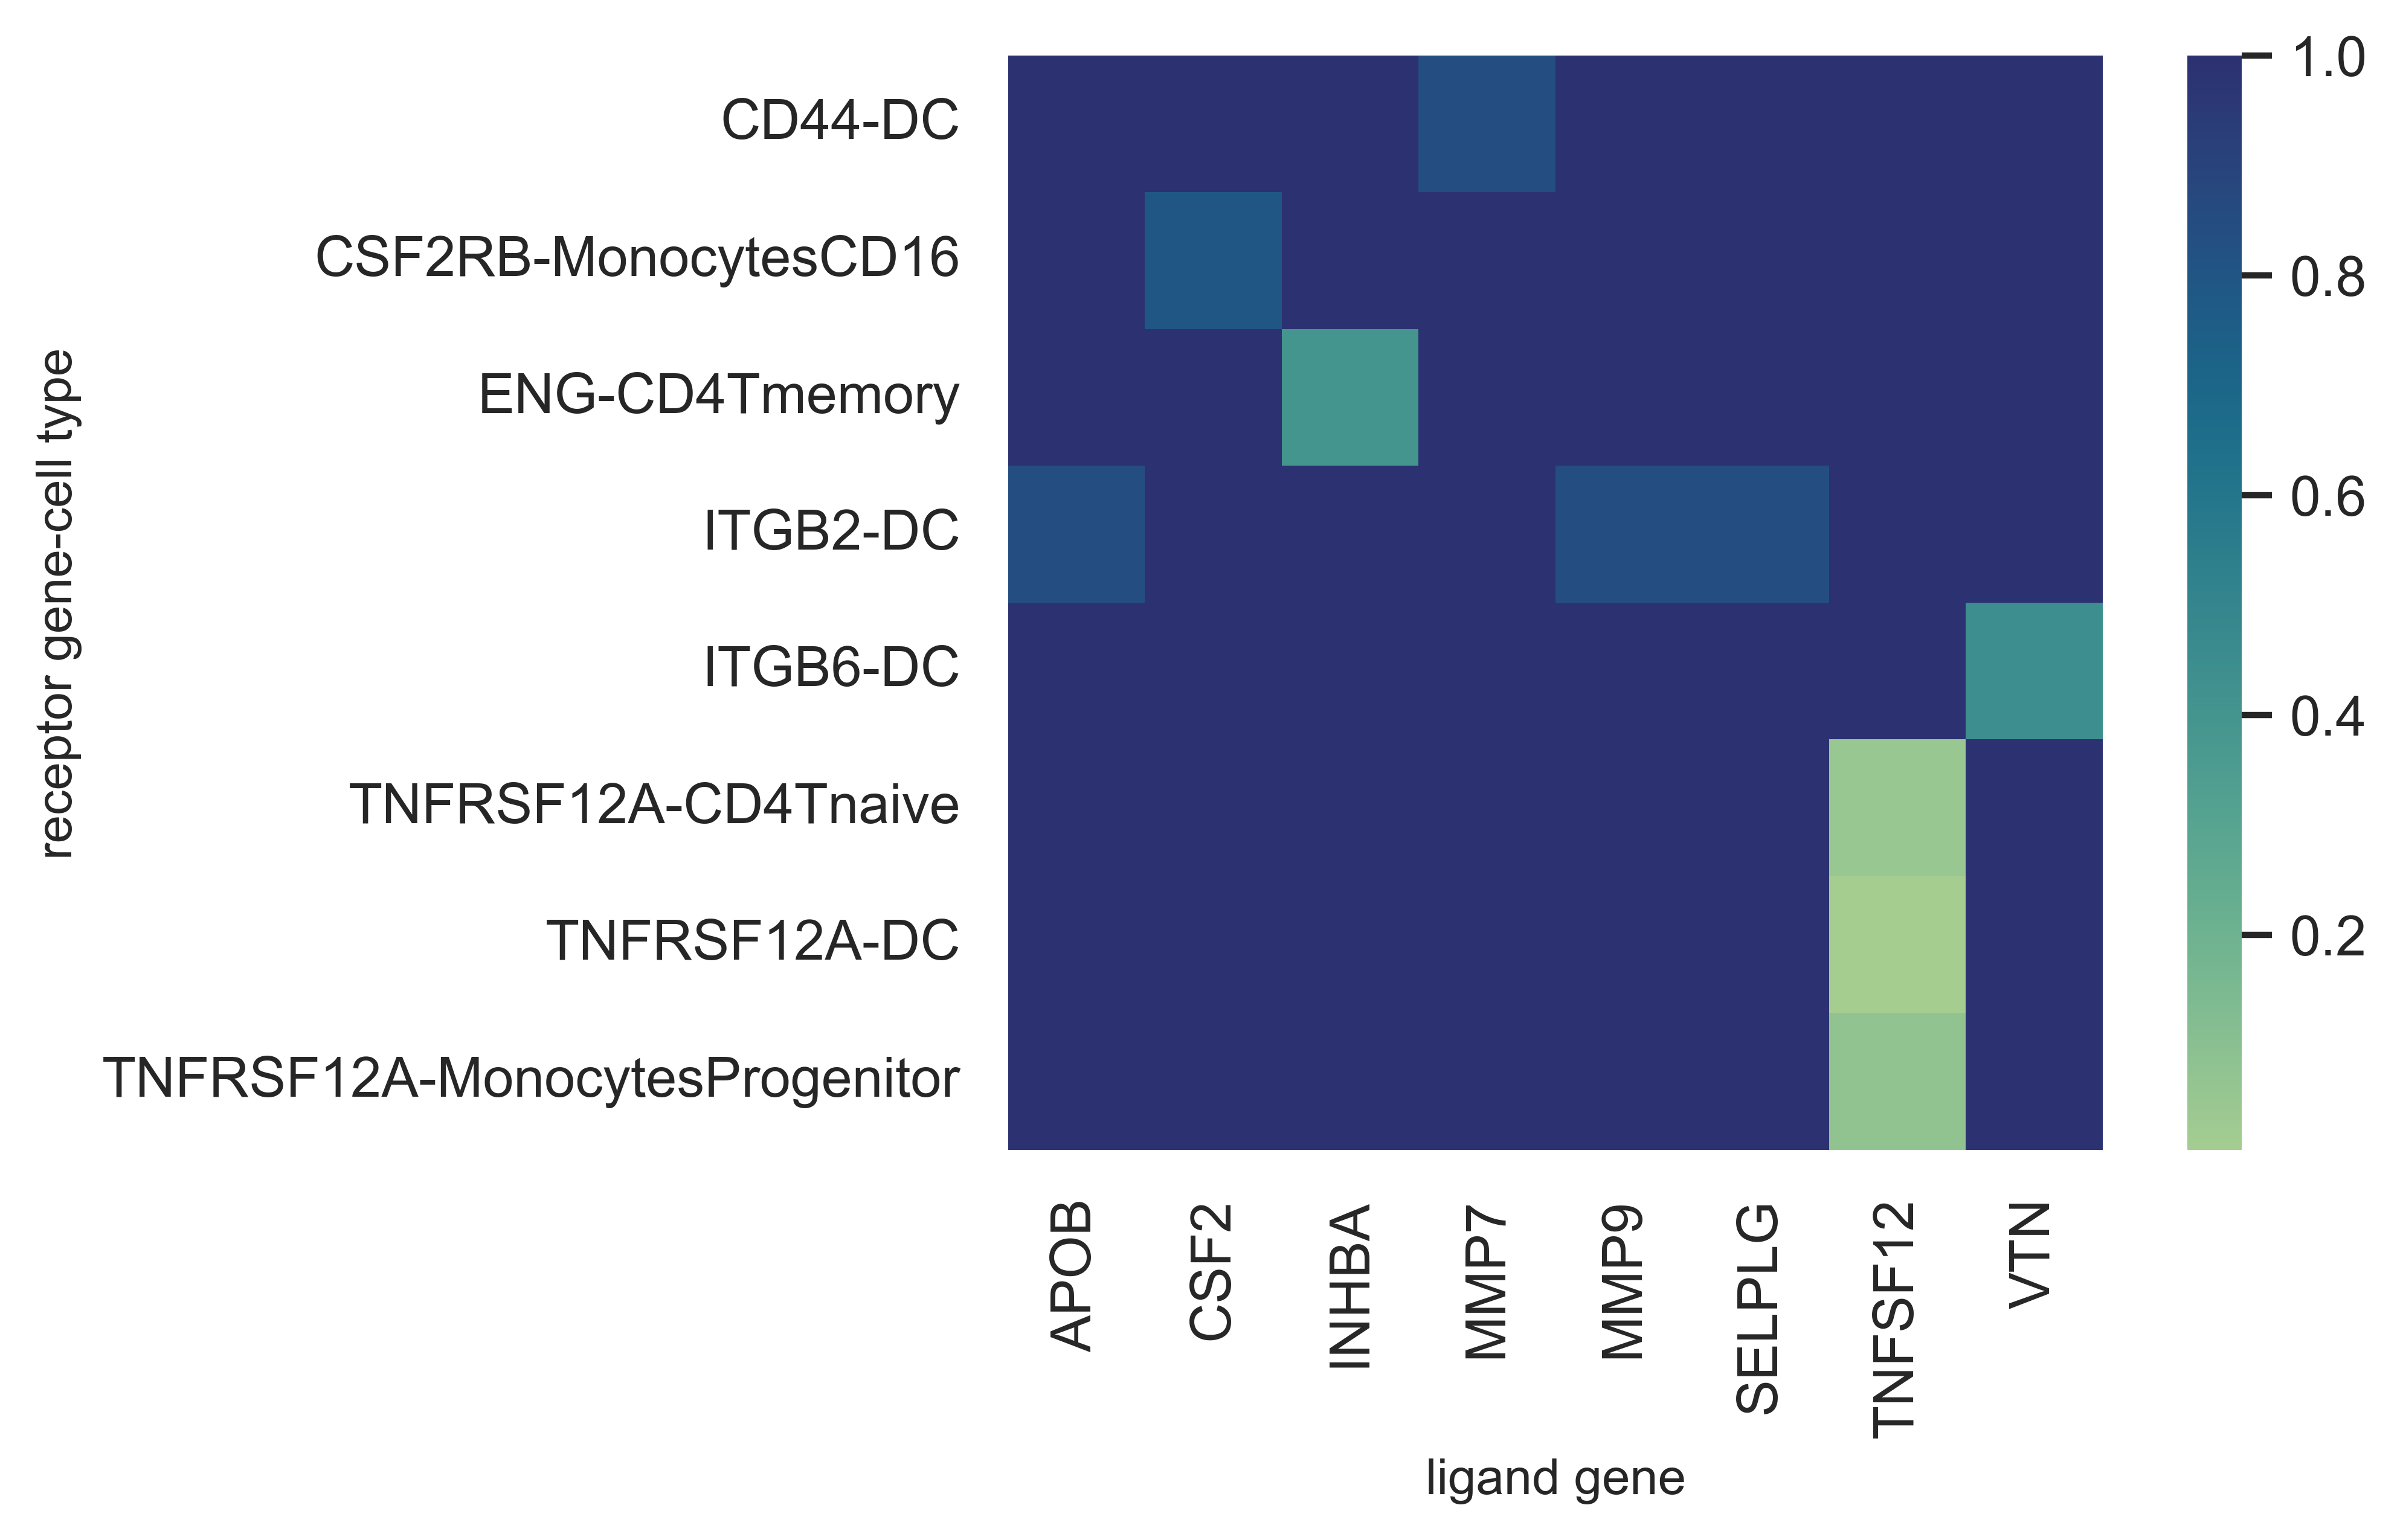

In [28]:
plt.figure(dpi=600)
sns.set(font="Arial")
sns.heatmap(LR_results_pivoted, cmap="crest", square=True)
plt.ylabel(r'receptor gene-cell type', font='arial', fontsize=10)
plt.xlabel(r'ligand gene', font='arial', fontsize=10)
plt.savefig('ligand_malig_heatmap.png', bbox_inches="tight")

### Receptor from leukemia, ligand from other

In [17]:
# load results csv
LR_results = pd.read_csv('LR_result2_update.csv', index_col=0)

# only look at pairs where close group reads elevated compared to far
LR_results['foldChange'] = LR_results['group0'] / LR_results['group1']
LR_results_up = LR_results[LR_results['foldChange'] > 0]

# only look at pairs where adjusted p < 1
LR_results_up_filt = LR_results_up[LR_results_up['p_adj'] < 1]
LR_results_up_filt

,ligand_gene,Timepoint,celltype,p,group0,group1,receptor_gene_malignant,patient,p_adj,foldChange
4096,MIF,C,DC,0.000622,0.754060,0.442434,CXCR2,1,0.893862,1.704343
7391,DLL1,C,MonocytesCD14,0.000155,0.112045,0.080033,NOTCH2,1,0.223465,1.399997
73911,DLL1,C,MonocytesCD14,0.000155,0.112045,0.080033,NOTCH3,1,0.223465,1.399997
9713,WIF1,B,CD4Tmemory,0.000275,0.481481,0.320000,RYK,3,0.395463,1.504630
9717,WIF1,B,CD8Tnaive,0.000553,0.528571,0.459184,RYK,3,0.795002,1.151111
9723,WIF1,B,MonocytesCD16,0.000275,0.393035,0.300448,RYK,3,0.395463,1.308161
13497,NPPC,B,CD4Tnaive,0.000085,1.488889,0.935897,NPR3,3,0.122308,1.590868
13500,NPPC,B,CD8Tnaive,0.000553,1.592814,1.243243,NPR3,3,0.795002,1.281177
13505,NPPC,B,MonocytesCD14,0.000128,1.477273,0.993915,NPR3,3,0.183462,1.486317
13507,NPPC,B,MonocytesProgenitor,0.000128,1.747312,1.244147,NPR3,3,0.183462,1.404425


In [18]:
LR_results_up_filt['celltype_gene'] = LR_results_up_filt['celltype'] + '_' + LR_results_up_filt['ligand_gene']
LR_results_up_filt

/tmp/ipykernel_3182471/2914321785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LR_results_up_filt['celltype_gene'] = LR_results_up_filt['celltype'] + '_' + LR_results_up_filt['ligand_gene']


,ligand_gene,Timepoint,celltype,p,group0,group1,receptor_gene_malignant,patient,p_adj,foldChange,celltype_gene
4096,MIF,C,DC,0.000622,0.754060,0.442434,CXCR2,1,0.893862,1.704343,DC_MIF
7391,DLL1,C,MonocytesCD14,0.000155,0.112045,0.080033,NOTCH2,1,0.223465,1.399997,MonocytesCD14_DLL1
73911,DLL1,C,MonocytesCD14,0.000155,0.112045,0.080033,NOTCH3,1,0.223465,1.399997,MonocytesCD14_DLL1
9713,WIF1,B,CD4Tmemory,0.000275,0.481481,0.320000,RYK,3,0.395463,1.504630,CD4Tmemory_WIF1
9717,WIF1,B,CD8Tnaive,0.000553,0.528571,0.459184,RYK,3,0.795002,1.151111,CD8Tnaive_WIF1
9723,WIF1,B,MonocytesCD16,0.000275,0.393035,0.300448,RYK,3,0.395463,1.308161,MonocytesCD16_WIF1
13497,NPPC,B,CD4Tnaive,0.000085,1.488889,0.935897,NPR3,3,0.122308,1.590868,CD4Tnaive_NPPC
13500,NPPC,B,CD8Tnaive,0.000553,1.592814,1.243243,NPR3,3,0.795002,1.281177,CD8Tnaive_NPPC
13505,NPPC,B,MonocytesCD14,0.000128,1.477273,0.993915,NPR3,3,0.183462,1.486317,MonocytesCD14_NPPC
13507,NPPC,B,MonocytesProgenitor,0.000128,1.747312,1.244147,NPR3,3,0.183462,1.404425,MonocytesProgenitor_NPPC


In [19]:
LR_results_pivoted = LR_results_up_filt.pivot(index='celltype_gene', columns='receptor_gene_malignant', values='p_adj')
LR_results_pivoted = LR_results_pivoted.fillna(1)
LR_results_pivoted

receptor_gene_malignant,CXCR2,NOTCH2,NOTCH3,NPR3,OLR1,RYK
celltype_gene,,,,,,
CD4Tmemory_WIF1,1.000000,1.000000,1.000000,1.000000,1.000000,0.395463
CD4Tnaive_NPPC,1.000000,1.000000,1.000000,0.122308,1.000000,1.000000
CD8Tnaive_NPPC,1.000000,1.000000,1.000000,0.795002,1.000000,1.000000
CD8Tnaive_WIF1,1.000000,1.000000,1.000000,1.000000,1.000000,0.795002
DC_CRP,1.000000,1.000000,1.000000,1.000000,0.837995,1.000000
DC_MIF,0.893862,1.000000,1.000000,1.000000,1.000000,1.000000
ErythroidProgenitors_CRP,1.000000,1.000000,1.000000,1.000000,0.837995,1.000000
MonocytesCD14_DLL1,1.000000,0.223465,0.223465,1.000000,1.000000,1.000000
MonocytesCD14_NPPC,1.000000,1.000000,1.000000,0.183462,1.000000,1.000000


In [20]:
LR_results_pivoted = LR_results_pivoted.reset_index()
LR_results_pivoted[['ligand_celltype','ligand_gene']] = LR_results_pivoted['celltype_gene'].str.split('_',expand=True)
del LR_results_pivoted['celltype_gene']
LR_results_pivoted = LR_results_pivoted.sort_values(by=['ligand_gene'])
LR_results_pivoted

receptor_gene_malignant,CXCR2,NOTCH2,NOTCH3,NPR3,OLR1,RYK,ligand_celltype,ligand_gene
4,1.000000,1.000000,1.000000,1.000000,0.837995,1.000000,DC,CRP
6,1.000000,1.000000,1.000000,1.000000,0.837995,1.000000,ErythroidProgenitors,CRP
7,1.000000,0.223465,0.223465,1.000000,1.000000,1.000000,MonocytesCD14,DLL1
5,0.893862,1.000000,1.000000,1.000000,1.000000,1.000000,DC,MIF
1,1.000000,1.000000,1.000000,0.122308,1.000000,1.000000,CD4Tnaive,NPPC
2,1.000000,1.000000,1.000000,0.795002,1.000000,1.000000,CD8Tnaive,NPPC
8,1.000000,1.000000,1.000000,0.183462,1.000000,1.000000,MonocytesCD14,NPPC
10,1.000000,1.000000,1.000000,0.183462,1.000000,1.000000,MonocytesProgenitor,NPPC
0,1.000000,1.000000,1.000000,1.000000,1.000000,0.395463,CD4Tmemory,WIF1
3,1.000000,1.000000,1.000000,1.000000,1.000000,0.795002,CD8Tnaive,WIF1


In [21]:
LR_results_pivoted = LR_results_pivoted.set_index(['ligand_gene', 'ligand_celltype'])
LR_results_pivoted

receptor_gene_malignant              CXCR2    NOTCH2    NOTCH3      NPR3  \
ligand_gene ligand_celltype                                                
CRP         DC                    1.000000  1.000000  1.000000  1.000000   
            ErythroidProgenitors  1.000000  1.000000  1.000000  1.000000   
DLL1        MonocytesCD14         1.000000  0.223465  0.223465  1.000000   
MIF         DC                    0.893862  1.000000  1.000000  1.000000   
NPPC        CD4Tnaive             1.000000  1.000000  1.000000  0.122308   
            CD8Tnaive             1.000000  1.000000  1.000000  0.795002   
            MonocytesCD14         1.000000  1.000000  1.000000  0.183462   
            MonocytesProgenitor   1.000000  1.000000  1.000000  0.183462   
WIF1        CD4Tmemory            1.000000  1.000000  1.000000  1.000000   
            CD8Tnaive             1.000000  1.000000  1.000000  1.000000   
            MonocytesCD16         1.000000  1.000000  1.000000  1.000000   

receptor_gene_malignant               OLR1       RYK  
ligand_gene ligand_celltype                           
CRP         DC                    0.837995  1.000000  
            ErythroidProgenitors  0.837995  1.000000  
DLL1        MonocytesCD14         1.000000  1.000000  
MIF         DC                    1.000000  1.000000  
NPPC        CD4Tnaive             1.000000  1.000000  
            CD8Tnaive             1.000000  1.000000  
            MonocytesCD14         1.000000  1.000000  
            MonocytesProgenitor   1.000000  1.000000  
WIF1        CD4Tmemory            1.000000  0.395463  
            CD8Tnaive             1.000000  0.795002  
            MonocytesCD16         1.000000  0.395463

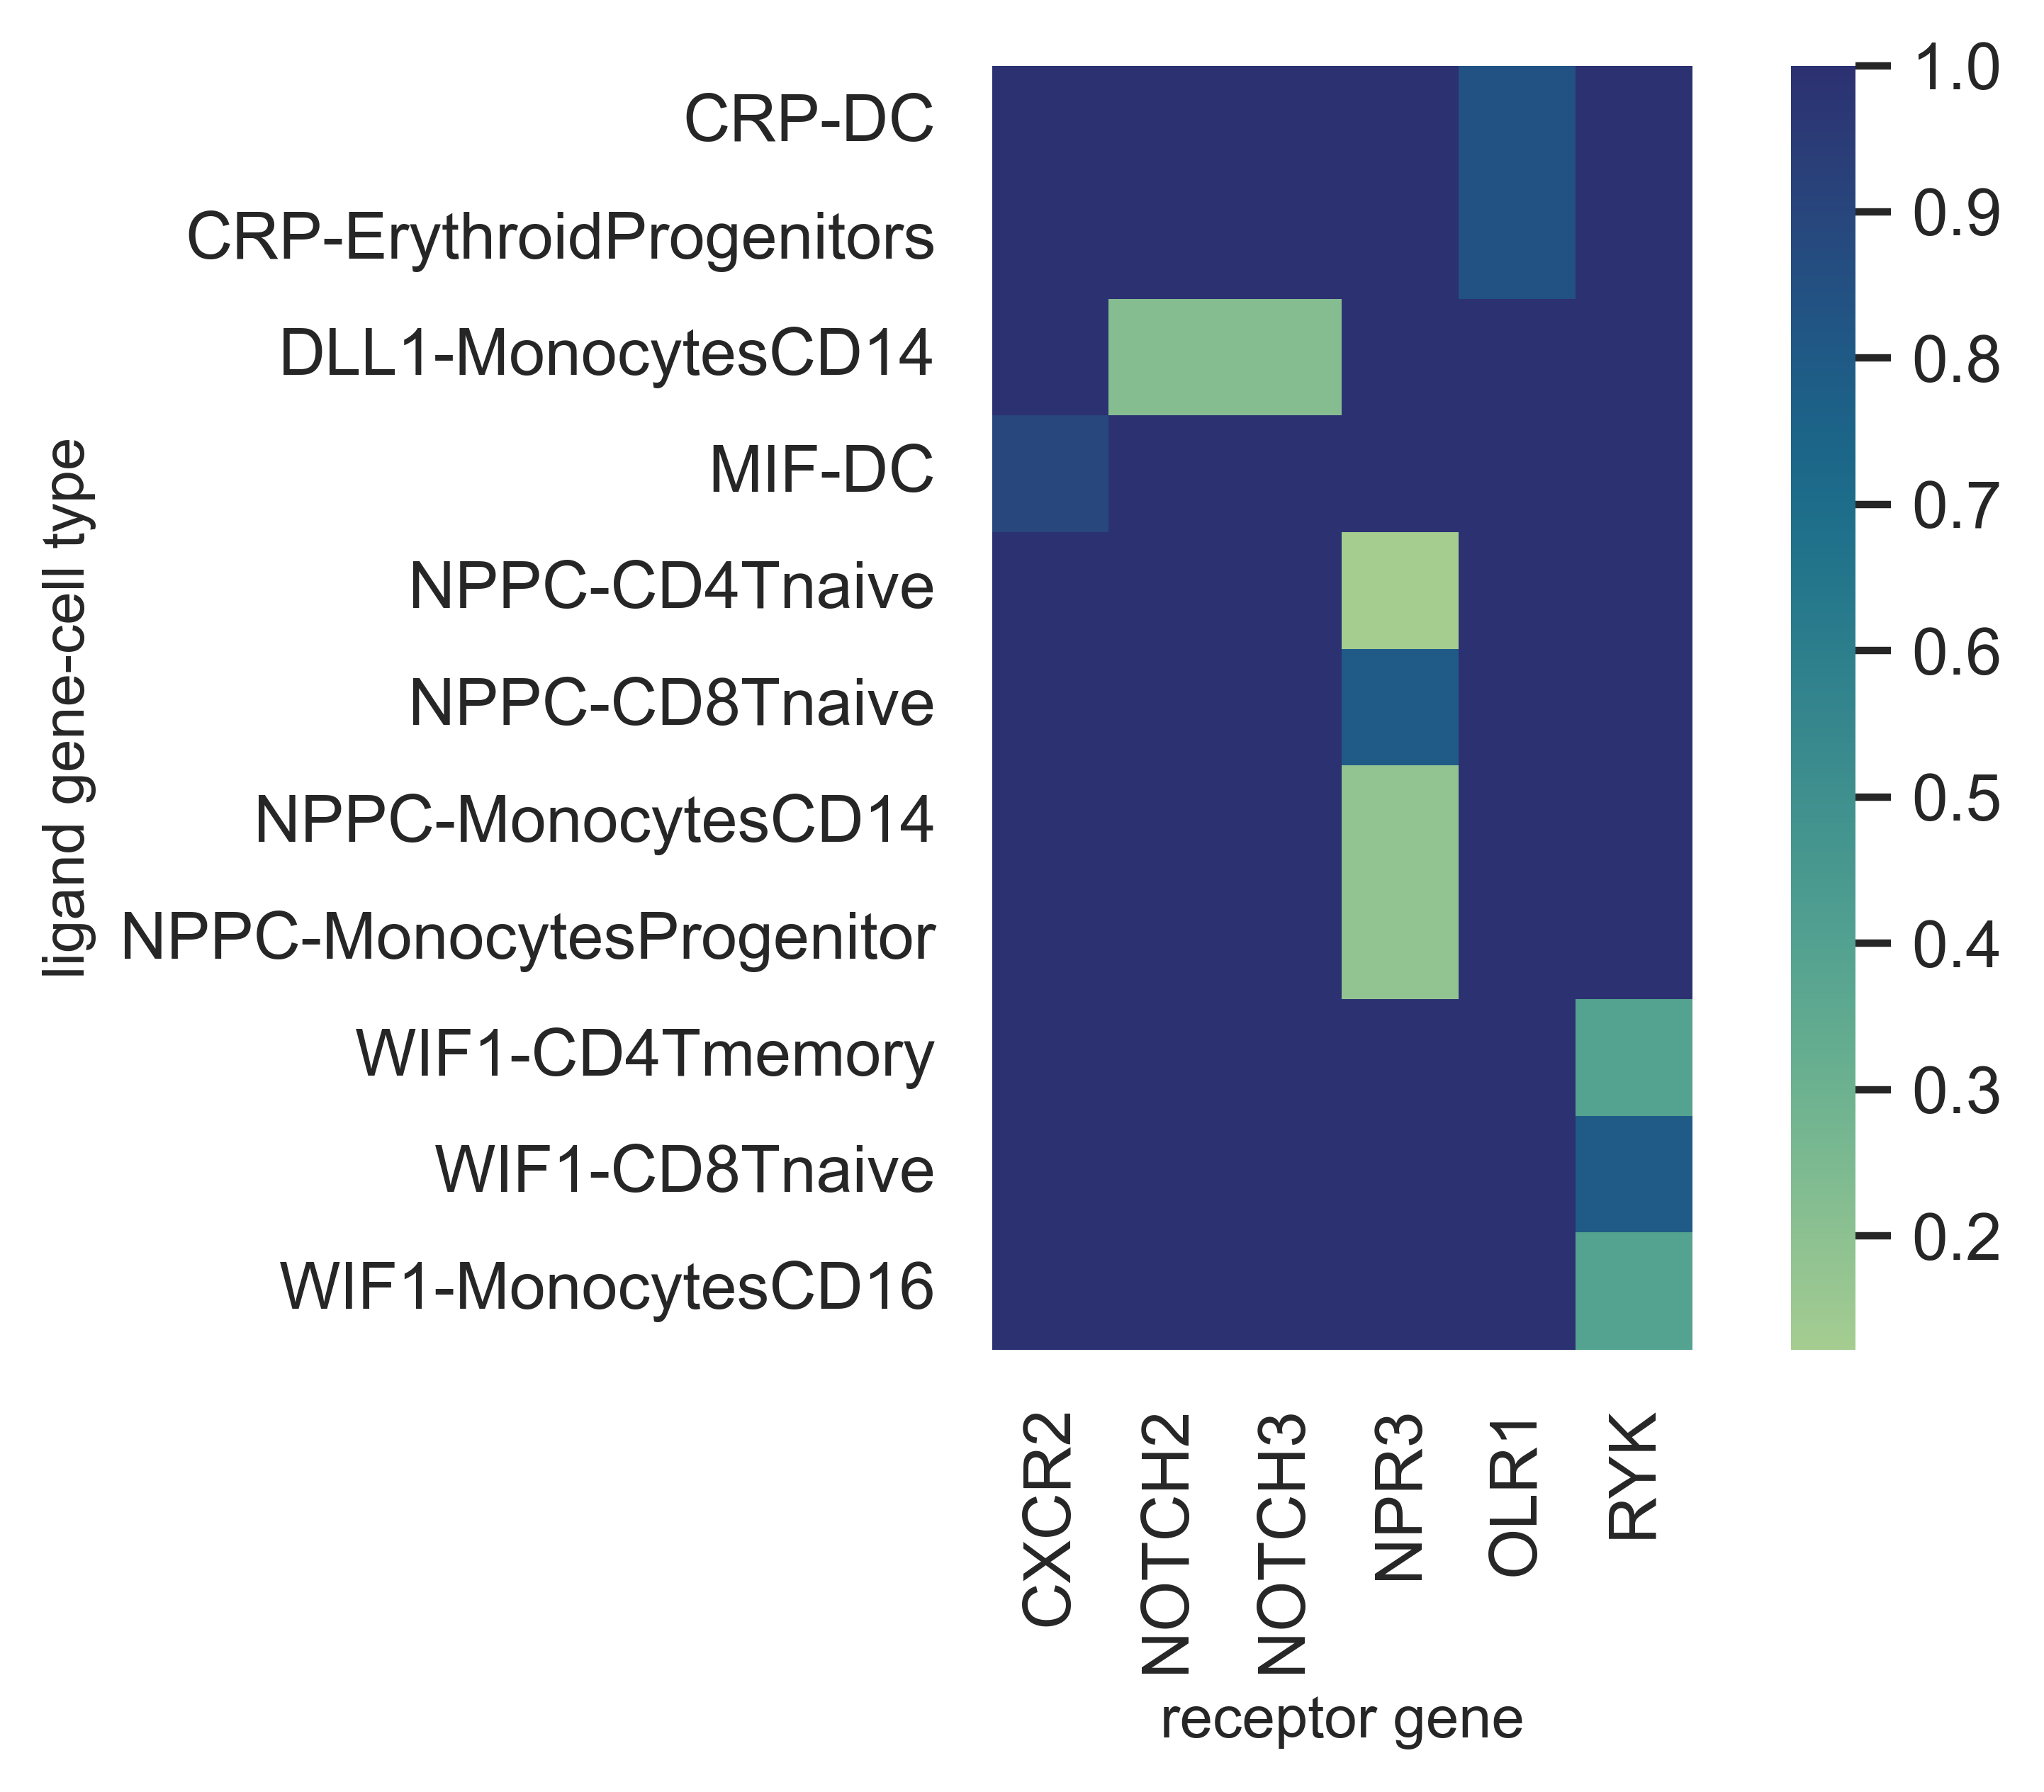

In [22]:
plt.figure(dpi=600)
sns.set(font="Arial")
sns.heatmap(LR_results_pivoted, cmap="crest", square=True)
plt.ylabel(r'ligand gene-cell type', font='arial', fontsize=10)
plt.xlabel(r'receptor gene', font='arial', fontsize=10)
plt.savefig('receptor_malig_heatmap.png', bbox_inches="tight")

# Visualize only selected FOVs

Define function to create visualization for each pair

In [33]:
def LRVisual(malig_gene, otherCell, other_gene, other_cell_color, patient, tp, fov):
    
    alt_pt_name = name_dirs[patient]
    
    # subset counts to one patient
    one_pt = All_fov_scores_df[All_fov_scores_df['patients'] == patient]
    # subset to one tp
    one_tp = one_pt[one_pt['Timepoint'] == tp]
    # subset to one FOV, cell types of interest
    one_fov = one_tp[one_tp['FOV'] == fov]
    one_fov = one_fov[one_fov['celltype_detail'].isin(['LeukemiaCell', otherCell])]

    # Calculate maximum expression of each marker for consistent color scaling
    max_malig_exp = one_fov[one_fov['celltype_detail'] == 'LeukemiaCell'][malig_gene].max()
    max_other_exp = one_fov[one_fov['celltype_detail'] == otherCell][other_gene].max()

    # Load masks
    location = '/data/Zhaolab/1_AMLCosMx/Final_scripts/2_Segmentation/3_NucMemMerging/' + alt_pt_name + '_hybrid/labels_predicted_2_15_24/'
    dirlist = os.listdir(location)
    dirlist.sort()
    for item in dirlist:
        if 'F0' + str(fov).zfill(2) in item:
            labels = tifffile.imread(location + item)
            break

    # blank array to add masks to
    blank = np.zeros([labels.shape[0], labels.shape[1], 3])
    blank = blank.astype('uint8')

    # malig IDs
    malig_cell_ids = one_fov[one_fov['celltype_detail'] == 'LeukemiaCell']
    malig_ids = malig_cell_ids['cell_id'].astype(int).tolist()

    # make all cells dark gray
    blank[labels > 0] = [75,75,75]

    # color leukemia cells on FOV
    for cell in malig_ids:
        read_num = malig_cell_ids[malig_gene].loc[patient + "_" + str(fov).zfill(2) + "_" + str(cell)]
        blank[labels == cell] = [ (x/(max_malig_exp+1))*(read_num+1) for x in cluster_colors['LeukemiaCell'] ]

    # get cell IDs of other celltype
    subset_ids = one_fov[one_fov['celltype_detail'] == otherCell]
    celltype_ids = subset_ids['cell_id'].tolist()

    # color other cells on FOV
    for cell in celltype_ids:
        read_num = subset_ids[other_gene].loc[patient + "_" + str(fov).zfill(2) + "_" + str(cell)]
        blank[labels == cell] = [ (x/(max_other_exp+1))*(read_num+1) for x in other_cell_color ]

    # add black outline
    boundaries = segmentation.find_boundaries(labels, connectivity=1, mode='inner', background=0)
    boundaries = boundaries.astype(int)
    blank[boundaries>0] = [0,0,0] # add black borders to cells

    # add contour lines
    labels_sub = labels.copy()
    labels_sub[~np.isin(labels,malig_ids)] = 0

    # expand cell area
    px_dist = int(5 / 0.18)
    expanded = expand_labels(labels_sub, distance=px_dist)
    # set all expanded masks to same value
    expanded[expanded > 0] = 1
    # add outline
    boundaries = segmentation.find_boundaries(expanded, connectivity=1, mode='thick', background=0)
    boundaries = boundaries.astype(int)
    blank[boundaries>0] = [255,255,255]

    # add color key in top corner (leukemia)
    xstart = 20
    xstop = 60
    ystart = 20 
    ystop = 60
    boxcolor = [255,0,255]
    blank = cv2.rectangle(blank, (xstart,ystart), (xstop,ystop), boxcolor, thickness=-1) 
    for i in list(range(int(max_malig_exp)-1,-1,-1)):
        dimmed_color = [ (x/(max_malig_exp+1))*(i+1) for x in boxcolor ]
        xstart += 40
        xstop += 40
        blank = cv2.rectangle(blank, (xstart,ystart), (xstop,ystop), dimmed_color, thickness=-1)
    
    # Using cv2.putText()
    blank = cv2.putText(
      img = blank,
      text = str(int(max_malig_exp)),
      org = (xstop+20, ystop),
      fontFace = cv2.FONT_HERSHEY_DUPLEX,
      fontScale = 1.5,
      color = (255, 255, 255),
      thickness = 2
    )
    
    # add color key in top corner (other)
    xstart = 20
    xstop = 60
    ystart = 80 
    ystop = 120
    boxcolor = other_cell_color
    blank = cv2.rectangle(blank, (xstart,ystart), (xstop,ystop), boxcolor, thickness=-1) 
    for i in list(range(int(max_other_exp)-1,-1,-1)):
        dimmed_color = [ (x/(max_other_exp+1))*(i+1) for x in boxcolor ]
        xstart += 40
        xstop += 40
        blank = cv2.rectangle(blank, (xstart,ystart), (xstop,ystop), dimmed_color, thickness=-1)
    
    # Using cv2.putText()
    blank = cv2.putText(
      img = blank,
      text = str(int(max_other_exp)),
      org = (xstop+20, ystop),
      fontFace = cv2.FONT_HERSHEY_DUPLEX,
      fontScale = 1.5,
      color = (255, 255, 255),
      thickness = 2
    )

    cv2.imwrite('LR_FOV_Visuals/FOVs_for_figure/Malig-' + malig_gene + '_' + otherCell + '-' + other_gene + '_' + patient + '_' + str(fov).zfill(2) + '.png', blank)
    
    return

Malig-WNT2_CD4Tnaive-FZD1, P1 FOV19

In [73]:
# define gene exp on malignant cells
malig_gene = 'WNT2'
    
# define other cell and gene
otherCell = 'CD4Tnaive'
other_gene = 'FZD1'
other_cell_color = [255, 0, 0] # blue for CD4T cell
    
# define pt, tp, and FOV
patient = 'p1'
tp = 'C'
fov = 19

# run function to create and save visualization
LRVisual(malig_gene, otherCell, other_gene, other_cell_color, patient, tp, fov)

Malig-WNT3_CD4Tnaive-FZD1, P1 FOV20

In [74]:
# define gene exp on malignant cells
malig_gene = 'WNT3'
    
# define other cell and gene
otherCell = 'CD4Tnaive'
other_gene = 'FZD1'
other_cell_color = [255, 0, 0] # blue for CD4T cell
    
# define pt, tp, and FOV
patient = 'p1'
tp = 'C'
fov = 20

# run function to create and save visualization
LRVisual(malig_gene, otherCell, other_gene, other_cell_color, patient, tp, fov)

Malig-FGF7_CD4Tnaive-FGFR3, P1 FOV15

In [75]:
# define gene exp on malignant cells
malig_gene = 'FGF7'
    
# define other cell and gene
otherCell = 'CD4Tnaive'
other_gene = 'FGFR3'
other_cell_color = [255, 0, 0] # blue for CD4T cell
    
# define pt, tp, and FOV
patient = 'p1'
tp = 'C'
fov = 15

# run function to create and save visualization
LRVisual(malig_gene, otherCell, other_gene, other_cell_color, patient, tp, fov)

Malig-ERBB2_MatureB-S100A4, P1 FOV19

In [79]:
# define gene exp on malignant cells
malig_gene = 'ERBB2'
    
# define other cell and gene
otherCell = 'MatureB'
other_gene = 'S100A4'
other_cell_color = [0, 215, 255] # yellow for mature B
    
# define pt, tp, and FOV
patient = 'p1'
tp = 'C'
fov = 19

# run function to create and save visualization
LRVisual(malig_gene, otherCell, other_gene, other_cell_color, patient, tp, fov)

Malig-FGF18_CD4Tnaive-FGFR3, P1 FOV15

In [76]:
# define gene exp on malignant cells
malig_gene = 'FGF18'
    
# define other cell and gene
otherCell = 'CD4Tnaive'
other_gene = 'FGFR3'
other_cell_color = [255, 0, 0] # blue for CD4T cell
    
# define pt, tp, and FOV
patient = 'p1'
tp = 'C'
fov = 15

# run function to create and save visualization
LRVisual(malig_gene, otherCell, other_gene, other_cell_color, patient, tp, fov)

Malig-BMPR1A_CD8Tnaive-BMP5, P1 FOV17

In [70]:
# define gene exp on malignant cells
malig_gene = 'BMPR1A'
    
# define other cell and gene
otherCell = 'CD8Tnaive'
other_gene = 'BMP5'
other_cell_color = [0, 255, 0] # green for CD8T cell
    
# define pt, tp, and FOV
patient = 'p1'
tp = 'C'
fov = 17

# run function to create and save visualization
LRVisual(malig_gene, otherCell, other_gene, other_cell_color, patient, tp, fov)

Malig-WNT3_CD8Tnaive-FZD7, P1 FOV22

In [71]:
# define gene exp on malignant cells
malig_gene = 'WNT3'
    
# define other cell and gene
otherCell = 'CD8Tnaive'
other_gene = 'FZD7'
other_cell_color = [0, 255, 0] # green for CD8T cell
    
# define pt, tp, and FOV
patient = 'p1'
tp = 'C'
fov = 22

# run function to create and save visualization
LRVisual(malig_gene, otherCell, other_gene, other_cell_color, patient, tp, fov)

Malig-WNT5A_CD4Tnaive-FZD1, P1 FOV15

In [72]:
# define gene exp on malignant cells
malig_gene = 'WNT5A'
    
# define other cell and gene
otherCell = 'CD4Tnaive'
other_gene = 'FZD1'
other_cell_color = [255, 0, 0] # blue for CD4T cell
    
# define pt, tp, and FOV
patient = 'p1'
tp = 'C'
fov = 15

# run function to create and save visualization
LRVisual(malig_gene, otherCell, other_gene, other_cell_color, patient, tp, fov)

Malig-TNFSF12_DC-TNFRSF12A, P3

In [58]:
# define gene exp on malignant cells
malig_gene = 'TNFSF12'
    
# define other cell and gene
otherCell = 'DC'
other_gene = 'TNFRSF12A'
other_cell_color = [0, 215, 255] # yellow for DC
    
# define pt, tp, and FOV
patient = 'p3'
tp = 'B'
fovs = [8, 9, 10, 13, 14, 15, 16, 17]

# run function to create and save visualization
for fov in fovs:
    LRVisual(malig_gene, otherCell, other_gene, other_cell_color, patient, tp, fov)

Malig-TNFSF12_MonocytesProgenitor-TNFRSF12A, P3

In [57]:
# define gene exp on malignant cells
malig_gene = 'TNFSF12'
    
# define other cell and gene
otherCell = 'MonocytesProgenitor'
other_gene = 'TNFRSF12A'
other_cell_color = [0, 255, 0] # green for MP
    
# define pt, tp, and FOV
patient = 'p3'
tp = 'B'
fovs = [8, 9, 10, 13, 14, 15, 16, 18]

# run function to create and save visualization
for fov in fovs:
    LRVisual(malig_gene, otherCell, other_gene, other_cell_color, patient, tp, fov)

Malig-TNFSF12_CD4Tnaive-TNFRSF12A, P3

In [34]:
# define gene exp on malignant cells
malig_gene = 'TNFSF12'
    
# define other cell and gene
otherCell = 'CD4Tnaive'
other_gene = 'TNFRSF12A'
other_cell_color = [240, 176, 0] # teal for CD4Tnaive
    
# define pt, tp, and FOV
patient = 'p3'
tp = 'B'
fovs = [8, 14, 16, 17]

# run function to create and save visualization
for fov in fovs:
    LRVisual(malig_gene, otherCell, other_gene, other_cell_color, patient, tp, fov)

Define function to LEGEND ONLY

In [35]:
def LRLegend(malig_gene, otherCell, other_gene, other_cell_color, patient, tp, fov):
    
    alt_pt_name = name_dirs[patient]
    
    # subset counts to one patient
    one_pt = All_fov_scores_df[All_fov_scores_df['patients'] == patient]
    # subset to one tp
    one_tp = one_pt[one_pt['Timepoint'] == tp]
    # subset to one FOV, cell types of interest
    one_fov = one_tp[one_tp['FOV'] == fov]
    one_fov = one_fov[one_fov['celltype_detail'].isin(['LeukemiaCell', otherCell])]

    # Calculate maximum expression of each marker for consistent color scaling
    max_malig_exp = one_fov[one_fov['celltype_detail'] == 'LeukemiaCell'][malig_gene].max()
    max_other_exp = one_fov[one_fov['celltype_detail'] == otherCell][other_gene].max()

    # blank array to add legend
    blank = np.full([150, 400, 3], 255, dtype=int)
    blank = blank.astype('uint8')

    # add color key in top corner (leukemia)
    xstart = 20
    xstop = 60
    ystart = 20 
    ystop = 60
    boxcolor = [255,0,255]
    blank = cv2.rectangle(blank, (xstart,ystart), (xstop,ystop), boxcolor, thickness=-1) 
    for i in list(range(int(max_malig_exp)-1,-1,-1)):
        dimmed_color = [ (x/(max_malig_exp+1))*(i+1) for x in boxcolor ]
        xstart += 40
        xstop += 40
        blank = cv2.rectangle(blank, (xstart,ystart), (xstop,ystop), dimmed_color, thickness=-1)
    
    # add color key in top corner (other)
    xstart = 20
    xstop = 60
    ystart = 80 
    ystop = 120
    boxcolor = other_cell_color
    blank = cv2.rectangle(blank, (xstart,ystart), (xstop,ystop), boxcolor, thickness=-1) 
    for i in list(range(int(max_other_exp)-1,-1,-1)):
        dimmed_color = [ (x/(max_other_exp+1))*(i+1) for x in boxcolor ]
        xstart += 40
        xstop += 40
        blank = cv2.rectangle(blank, (xstart,ystart), (xstop,ystop), dimmed_color, thickness=-1)
    

    cv2.imwrite('LR_FOV_Visuals/FOVs_for_figure/Legend_Malig-' + malig_gene + '_' + otherCell + '-' + other_gene + '_' + patient + '_' + str(fov).zfill(2) + '.png', blank)
    
    return

Malig-TNFSF12_DC-TNFRSF12A, P3 LEGEND

In [136]:
# define gene exp on malignant cells
malig_gene = 'TNFSF12'
    
# define other cell and gene
otherCell = 'DC'
other_gene = 'TNFRSF12A'
other_cell_color = [0, 215, 255] # yellow for DC
    
# define pt, tp, and FOV
patient = 'p3'
tp = 'B'
fovs = [8, 9, 10, 13, 14, 15, 16, 17]

# run function to create and save visualization
for fov in fovs:
    LRLegend(malig_gene, otherCell, other_gene, other_cell_color, patient, tp, fov)

Malig-TNFSF12_MP-TNFRSF12A, P3 LEGEND

In [137]:
# define gene exp on malignant cells
malig_gene = 'TNFSF12'
    
# define other cell and gene
otherCell = 'MonocytesProgenitor'
other_gene = 'TNFRSF12A'
other_cell_color = [0, 255, 0] # green for MP
    
# define pt, tp, and FOV
patient = 'p3'
tp = 'B'
fovs = [8, 9, 10, 13, 14, 15, 16, 18]

# run function to create and save visualization
for fov in fovs:
    LRLegend(malig_gene, otherCell, other_gene, other_cell_color, patient, tp, fov)

Malig-TNFSF12_CD4Tnaive-TNFRSF12A, P3 LEGEND

In [36]:
# define gene exp on malignant cells
malig_gene = 'TNFSF12'
    
# define other cell and gene
otherCell = 'CD4Tnaive'
other_gene = 'TNFRSF12A'
other_cell_color = [240, 176, 0] # green for MP
    
# define pt, tp, and FOV
patient = 'p3'
tp = 'B'
fovs = [8, 14, 16, 17]

# run function to create and save visualization
for fov in fovs:
    LRLegend(malig_gene, otherCell, other_gene, other_cell_color, patient, tp, fov)